# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = True  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)

Loading predictions from ./saved_predictions/c4edd9e6f547a8c141912eb44bd213de1434da405cabfd109c418af3b7f1f68a.pkl
Predictions already exist, loading them...
Loading predictions from ./saved_predictions/21333807a5cd913fa4ee3bfd055054ad079c7dc84c1579faf951ee3baa9f2461.pkl
Predictions already exist, loading them...


# New Tests

In [ ]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="hausdorff",
    multiple_testing_correction=None,
    confidence_method="box_count_threshold",  # "nb_boxes",
    localization_method="pixelwise",
    localization_prediction_set="additive",
    classification_method="lac",
    optimizer="binary_search",
)

[WARNING:cp.py:cp:1264 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[INFO:cp.py:cp:179 - __init__ ] Defaulting to CRC backend
[INFO:cp.py:cp:932 - __init__ ] Defaulting to CRC backend


In [7]:
# TODO(leo): we can replace this by anything, doesn't even need a guarantee (confidence)
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.003,
    alpha_localization=0.05,
    alpha_classification=0.05,
)


[INFO:cp.py:cp:1490 - calibrate ] Calibrating Confidence Conformalizer
  0%|          | 0/13 [00:00<?, ?it/s]

[1.00, 1.00] -> [0.9998779296875]. Corrected Risk = 1.00:  92%|█████████▏| 12/13 [00:20<00:01,  1.74s/it][ERROR:optim.py:optim:81 - optimize ] No satisfactory solution of binary search found.
[1.00, 1.00] -> [0.9998779296875]. Corrected Risk = 1.00:  92%|█████████▏| 12/13 [00:20<00:01,  1.71s/it]
[0.50, 1.00] -> [0.75]. Corrected Risk = 1.00:  15%|█▌        | 2/13 [00:02<00:14,  1.33s/it]


KeyboardInterrupt: 

8.3325


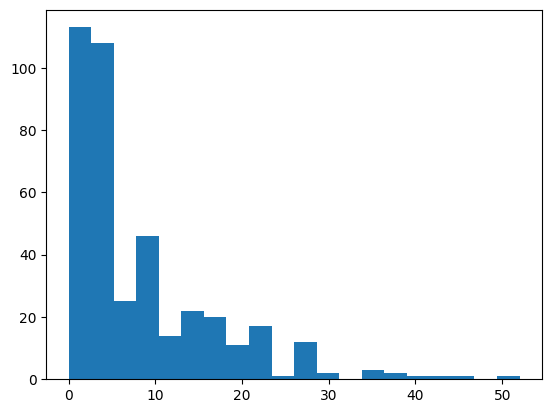

In [ ]:
lengths3 = [len(x) for x in preds_val.true_boxes]
import matplotlib.pyplot as plt
import numpy as np
plt.hist(lengths3,bins=20);
print(np.mean(lengths3))

41.9975


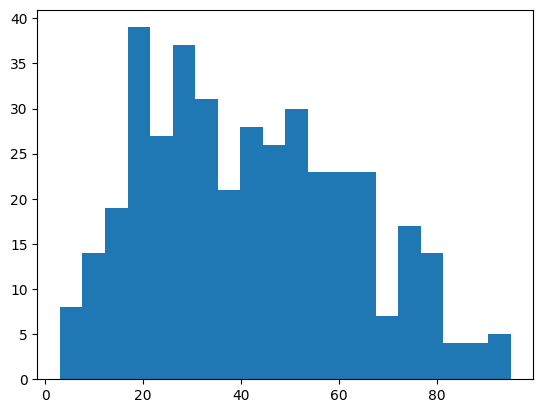

In [ ]:
lengths = [len(x) for x in preds_val.confidence]
import matplotlib.pyplot as plt
import numpy as np
plt.hist(lengths,bins=20);
print(np.mean(lengths))

7.8975


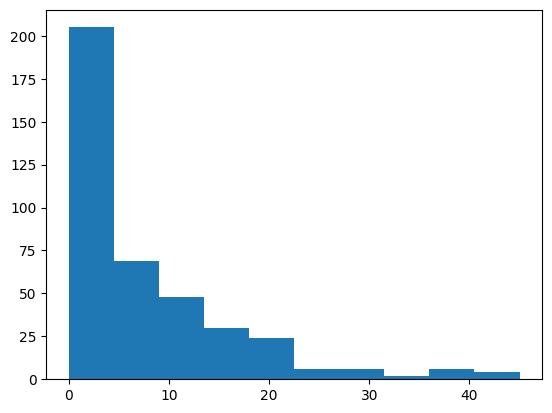

In [ ]:
lengths2 = [sum(x>preds_cal.confidence_threshold) for x in preds_val.confidence]
import matplotlib.pyplot as plt
import numpy as np
plt.hist(lengths2,bins=10);
print(np.mean(lengths2))

Using confidence threshold from preds


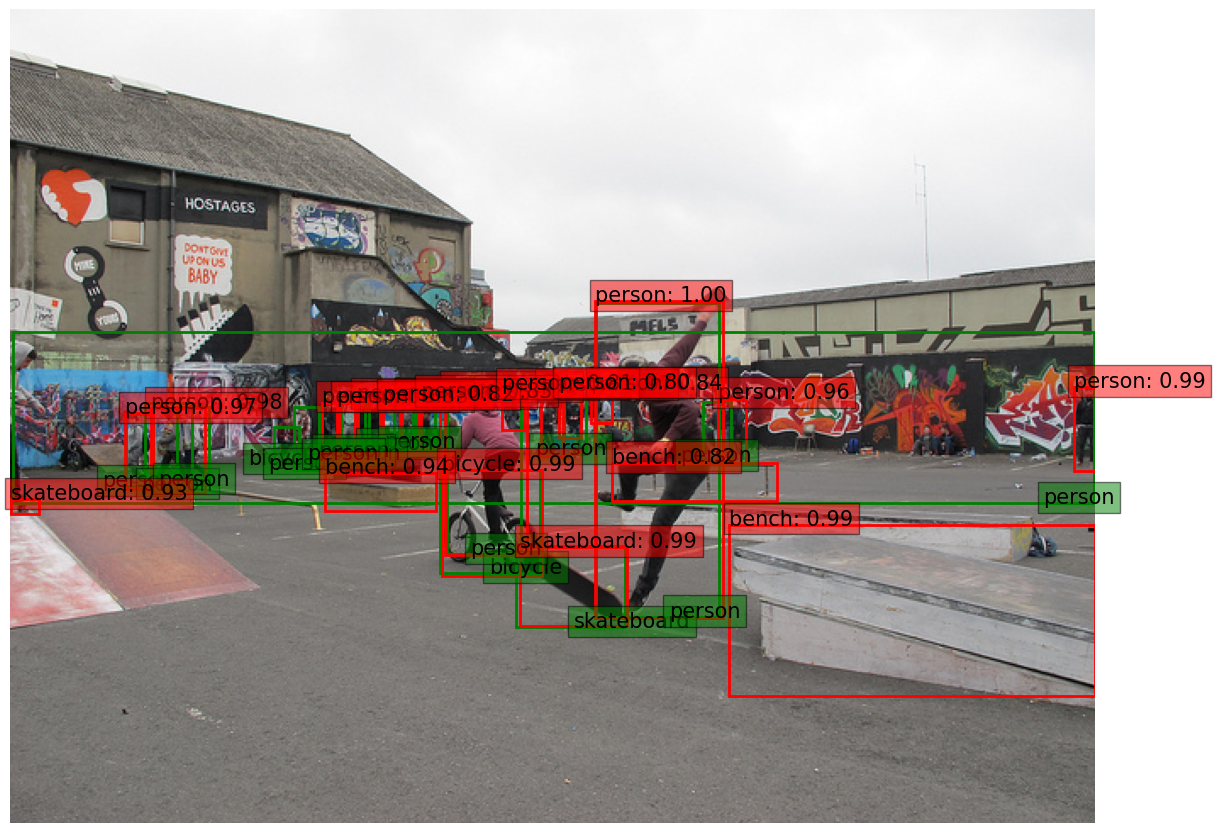

Number of ground truths: 17
Number of predictions: 80
Number of filtered prediction: 22


In [ ]:
from cods.od.visualization import plot_preds

# Plot ground truths and predictions for the image with index 0
idx = 3
plot_preds(idx, preds_cal, None, idx_to_label=MSCOCODataset.NAMES)
print("Number of ground truths:", len(preds_cal.true_cls[idx]))
print("Number of predictions:", len(preds_cal.confidence[idx]))
print("Number of filtered prediction:", sum(preds_cal.confidence[idx]>preds_cal.confidence_threshold).item())

In [ ]:
print(preds_cal.confidence_threshold)

0.784912109375


In [ ]:
conformal_preds = conf.conformalize(preds_val, parameters=parameters)

[INFO:cp.py:cp:1603 - conformalize ] Conformalizing Predictions
[INFO:cp.py:cp:1606 - conformalize ] Using provided parameters for conformalization
[INFO:cp.py:cp:1612 - conformalize ] The parameters have been computed on another set of predictions.
[INFO:cp.py:cp:1624 - conformalize ] Conformalizing Confidence
[INFO:cp.py:cp:1640 - conformalize ] Conformalizing Localization
[INFO:cp.py:cp:511 - conformalize ] Using previous λ for localization
[INFO:cp.py:cp:526 - conformalize ] Conformalizing Localization with λ
[INFO:cp.py:cp:1650 - conformalize ] Conformalizing Classification


In [ ]:
# TODO: Rewrite it so we only compute the confidence loss and not the max of three. Main loss of condiecne shoudl be just itself but in calibration use the proxy maximum loss with the others
results_val = conf.evaluate(
    preds_val,
    parameters=parameters,
    conformalized_predictions=conformal_preds,
    include_confidence_in_global=False,
)

[INFO:cp.py:cp:1690 - evaluate ] Evaluating Confidence Conformalizer
[INFO:cp.py:cp:1703 - evaluate ] Evaluating Localization Conformalizer


[INFO:cp.py:cp:1716 - evaluate ] Evaluating Classification Conformalizer
100%|██████████| 400/400 [00:01<00:00, 314.37it/s]
[INFO:cp.py:cp:1746 - evaluate ] Evaluation Results:
[INFO:cp.py:cp:1748 - evaluate ] 	 Confidence:
[INFO:cp.py:cp:1749 - evaluate ] 		 Risk: 0.07
[INFO:cp.py:cp:1750 - evaluate ] 		 Mean Set Size: 7.90
[INFO:cp.py:cp:1754 - evaluate ] 	 Localization:
[INFO:cp.py:cp:1755 - evaluate ] 		 Risk: 0.03
[INFO:cp.py:cp:1756 - evaluate ] 		 Mean Set Size: 4.45
[INFO:cp.py:cp:1760 - evaluate ] 	 Classification:
[INFO:cp.py:cp:1761 - evaluate ] 		 Risk: 0.04
[INFO:cp.py:cp:1762 - evaluate ] 		 Mean Set Size: 46.04
[INFO:cp.py:cp:1766 - evaluate ] 	 Global:
[INFO:cp.py:cp:1767 - evaluate ] 		 Risk: 0.06


In [ ]:
plot_preds(idx, preds_cal, conformal_preds, idx_to_label=MSCOCODataset.NAMES)


Using confidence threshold from preds


IndexError: The shape of the mask [80] at index 0 does not match the shape of the indexed tensor [24, 4] at index 0

In [ ]:
conf.localization_conformalizer.lambda_localization

63.1103515625

In [ ]:
(
    results_val.classification_coverages.mean(),
    results_val.classification_set_sizes.mean(),
)

(tensor(0.0402), tensor(46.0431))

In [ ]:
preds_val.image_shapes

[(640, 480),
 (640, 426),
 (640, 480),
 (500, 375),
 (640, 427),
 (426, 640),
 (500, 375),
 (375, 500),
 (427, 640),
 (333, 500),
 (640, 480),
 (640, 480),
 (640, 480),
 (640, 480),
 (640, 403),
 (640, 427),
 (426, 640),
 (640, 427),
 (640, 480),
 (640, 480),
 (612, 612),
 (640, 425),
 (480, 640),
 (640, 427),
 (640, 428),
 (640, 344),
 (640, 471),
 (500, 378),
 (375, 500),
 (500, 375),
 (640, 480),
 (480, 640),
 (500, 375),
 (640, 427),
 (640, 427),
 (640, 480),
 (640, 427),
 (640, 457),
 (640, 480),
 (640, 315),
 (640, 427),
 (375, 500),
 (640, 480),
 (640, 427),
 (426, 640),
 (418, 640),
 (411, 640),
 (640, 480),
 (640, 480),
 (426, 640),
 (500, 375),
 (640, 427),
 (640, 404),
 (640, 427),
 (427, 640),
 (375, 500),
 (528, 640),
 (640, 480),
 (640, 480),
 (500, 375),
 (480, 640),
 (480, 640),
 (500, 375),
 (640, 480),
 (640, 480),
 (640, 360),
 (640, 400),
 (640, 639),
 (640, 480),
 (640, 480),
 (640, 425),
 (640, 480),
 (511, 640),
 (480, 640),
 (640, 514),
 (640, 480),
 (640, 399),

In [ ]:
preds_val.pred_cls[11].shape

torch.Size([21, 91])

In [ ]:
import torch

(
    torch.concatenate(preds_val.true_cls).max(),
    torch.concatenate(preds_val.true_cls).min(),
)

(tensor(90), tensor(1))

In [ ]:

print("number of objects", len(preds_val.true_cls[11]))
print("number of predictions", len(preds_val.pred_cls[11]))
print(results_val.classification_set_sizes[11])
print(results_val.classification_coverages[11])

number of objects 2
number of predictions 21
tensor(55.)
tensor(0.)


In [ ]:
from cods.od.visualization import plot_preds
from cods.od.data.datasets import MSCOCODataset

plot_preds(preds_val, conformal_preds, 11, idx_to_label=MSCOCODataset.NAMES)

AttributeError: 'ODConformalizedPredictions' object has no attribute 'image_paths'

In [ ]:
from cods.od.metrics import unroll_metrics

unroll_metrics(preds_val, conformal_preds)

Defaulting to predictions' confidence threshold


TypeError: getAveragePrecision() got multiple values for argument 'verbose'